In [3]:
import pandas as pd
# from sklearnex import patch_sklearn
# patch_sklearn()
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from data_prep import add_artists_as_features
import nltk
# Need to download stopwords and punkt to use the add_artists_as_features function
nltk.download('stopwords')
nltk.download('punkt')

pd.options.display.max_columns = 200

songs = pd.read_csv('../data/spotify_simplified.csv', index_col=[0])
songs_data = add_artists_as_features(songs, 2000)
songs_data = songs_data.drop(columns = ["track_id", "artists", "album_name", "track_name", "track_genre"])
genres = songs["track_genre"]
# Numerically encode the labels
label_encoder = LabelEncoder()
encoded_genres = label_encoder.fit_transform(genres)
# Using stratify might help because we have an imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(songs_data, encoded_genres, test_size=0.3, 
                                                    stratify=encoded_genres, shuffle=True, random_state=100)
# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)
# Evaluate model
predictions = model.predict(X_test)
base_accuracy = accuracy_score(y_test, predictions)
base_f1_weighted = f1_score(y_test, predictions, average='weighted')
print("Peformance using Random Forest")
print(f"Accuracy: {base_accuracy}")
print(f"F1-score: {base_f1_weighted}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\masam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Peformance using Random Forest
Accuracy: 0.6658866354654186
F1-score: 0.6609880116044151


In [4]:
def generate_predicitons_df(y_test, predictions, class_names):
    # Get more detailed performance information for each class
    f1 = f1_score(y_test, predictions, average=None)
    class_to_f1 = dict(zip(class_names, f1))
    # Sort f1-score in descending order
    class_to_f1 = dict(sorted(class_to_f1.items(), key=lambda item: item[1], reverse=True))
    grouped_by_genre = songs.groupby(['track_genre']).size()
    genre_count = grouped_by_genre.sort_values(ascending=False)
    count = list()
    for genre in class_to_f1.keys():
        count.append(genre_count[genre])
    predictions_df = pd.DataFrame([], columns=['genre', 'f1-score', 'count'])
    predictions_df['genre'] = class_to_f1.keys()
    predictions_df['f1-score'] = class_to_f1.values()
    predictions_df['count'] = count
    return predictions_df

predictions_df = generate_predicitons_df(y_test, predictions, label_encoder.classes_)
display(predictions_df)

,genre,f1-score,count
0,sleep,0.929293,998
1,comedy,0.915194,990
2,classical,0.814768,2655
3,techno,0.805778,8002
4,children,0.771502,2911
5,country,0.759283,2902
6,metal,0.752450,5999
7,ambient,0.721171,6066
8,latin,0.697463,8908
9,world,0.634294,6230


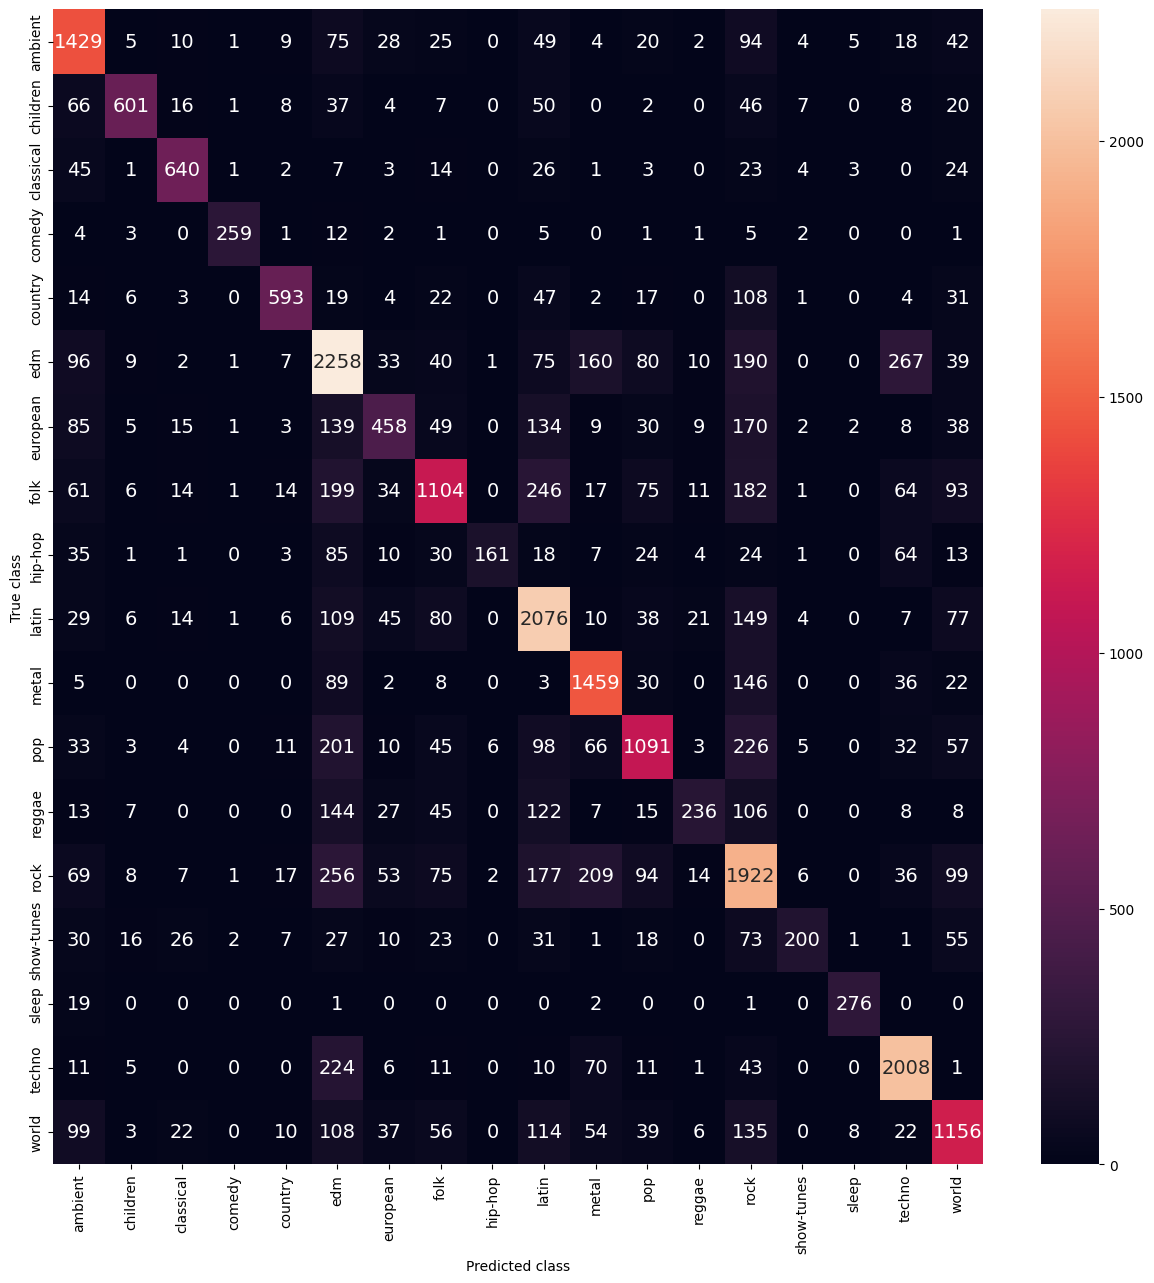

<Figure size 1000x3000 with 0 Axes>

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    heatmap = sns.heatmap(cm_df, annot=True, fmt='d', annot_kws={"size": 14})
    heatmap.set(xlabel='Predicted class', ylabel='True class')
    return heatmap

cm = confusion_matrix(y_test, predictions)
heatmap = plot_confusion_matrix(cm, label_encoder.classes_)
plt.figure(figsize=[10, 30])
plt.show()